## Setup

In [1]:
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import math
import copy

from scipy.ndimage import gaussian_filter

In [2]:
# Load MNIST data
images = np.load("data/train_images.npy") / 255  # mnist.train_images()
labels = np.load("data/train_labels.npy")  # mnist.train_labels()

test_images = np.load("data/test_images.npy") / 255  # mnist.test_images()
test_labels = np.load("data/test_labels.npy")  # mnist.test_labels()

DIGIT = 5

images_of_digit = images[labels == DIGIT]
test_images_of_digit = test_images[test_labels == DIGIT]

data = images_of_digit.reshape(len(images_of_digit), -1)  # Flatten the images
test_data = test_images_of_digit.reshape(
    len(test_images_of_digit), -1
)  # Flatten the images

## Helper Functions

In [7]:
def get_patches(data, patch_size, idx):
    """Extract Patches
    X - all patches before patch with index idx
    Y patch with index idx
    """
    X = data[:, : idx * patch_size]
    Y = data[:, idx * patch_size : (idx + 1) * patch_size]
    return X, Y


def get_patches_means(data, patch_size, idx):
    X = data[:, : idx * patch_size]
    means = np.zeros(shape=(data.shape[0], idx))
    for i in range(idx):
        tmp_means = X[:, i * patch_size : (i + 1) * patch_size].mean(axis=1)
        means[:, i] = tmp_means

    return means


def get_convolutions(data, a, b, dim_of_square, step_x=1, step_y=1):
    squares_indexes = []
    for i in range(0, dim_of_square - a + 1, step_x):  # columns
        for j in range(0, dim_of_square - b + 1, step_y):  # rows
            indexes = [
                i + x + y * 28 + j * 28 for y in range(b) for x in range(a)
            ]
            squares_indexes += indexes
    return data[:, squares_indexes]


def undo_convolutions(data, a, b, dim_of_square, step_x=1, step_y=1):
    squares_indexes = []
    original_imgs = np.zeros(data.shape)
    for i in range(0, dim_of_square - a + 1, step_x):  # columns
        for j in range(0, dim_of_square - b + 1, step_y):  # rows
            indexes = [
                i + x + y * 28 + j * 28 for y in range(b) for x in range(a)
            ]
            squares_indexes += indexes

    original_imgs[:, squares_indexes] = data
    return original_imgs


def blurr_data(data, sigma):
    blurred = np.apply_along_axis(
        gaussian_filter, axis=1, arr=data, sigma=sigma
    )
    return blurred


def get_neighbour_patches(idx, dim, patch_num, with_idx=False):
    u = idx - 1
    d = idx + 1
    l = idx - 28 // dim
    r = idx + 28 // dim
    luc = l - 1
    ruc = r - 1
    rdc = r + 1
    ldc = l + 1
    if d % (28 // dim) == 0:
        d, rdc, ldc = -1, -1, -1
    if u % (28 // dim) == 13:
        u, ruc, luc = -1, -1, -1

    if with_idx:
        patches_to_look = [l, luc, u, ruc, idx, r, rdc, d, ldc]
    else:
        patches_to_look = [l, luc, u, ruc, r, rdc, d, ldc]
    res = []
    for p in patches_to_look:
        if p < 0 or p >= patch_num:
            pass
        else:
            res.append(p)
    return res


def get_surr_patches(data, dim, patch_size, patch_idx, patch_num):
    patches_to_look = get_neighbour_patches(patch_idx, dim, patch_num)
    patch_idxs = []
    for p in patches_to_look:
        patch_idxs += list(range(patch_size * p, patch_size * (p + 1)))
    return data[:, patch_idxs]

## Architecture

First, we extract subsequent squares (patches) of dimension  from the image and permute them so that the pixels from each patch are adjacent to each other in a flattened vector of the image. Next, we extract the mean values from these patches as additional features.

This permutation preserves the structural information of the image when we extract the mean values from the patches.

Intially, the pixels were in the following order: 







Then, we created $195$ $f_i$ XGBoost regression models. We experimented with different parameters and set the maximum depth of the tree models to 7, and the number of estimators to 50. Each of the models was responsible for predicting one patch. The model $f_i$ predicts the $i+1$-th patch. $i$-th model was trained with a flattened vector containing patches $0,1,2,...,i$ and the means $m_1,m_2,...,m_i$ of each patch.

Additionally we created $196$ $r_i$ XGBoost regression models to refine the patches. The $r_i$ was trained with a slighly blurred $i$-th patch (extracted from the image blurred with a Gaussian kernel with $\sigma=1$). It predicts the original (non-blurred) pixels of the $i$-th patch.

First, we extract subsequent squares (patches) of dimension $2x2$ from the image and permute them so that the pixels from each patch are adjacent to each other in a flattened vector of the image. Next, we extract the mean values from these patches as additional features.

This permutation preserves the structural information of the image when we extract the mean values from the patches.

Initially, the pixels were in the following order: 

$$p_1,p_2,...p_{784}$$

After our permutation, where we extracted 196 squares of dimension $2x2$, the pixels were in the following order:

$$p_1,p_2,p_{29},p_{30},p_4,p_5,p_{31},p_{32},...,p_{756},p_{757},p_{783},p_{784}$$

Then, we created $195$ $f_i$ XGBoost regression models. We experimented with different parameters and set the maximum depth of the tree models to 7 and the number of estimators to 50. Each of the models was responsible for predicting one patch. The model $f_i$ predicts the $i+1$-th patch. The $i$-th model was trained with a flattened vector containing patches 0, 1, 2, \ldots, $i$ and the means $m_1, m_2, \ldots, m_i$ of each patch.

Additionally, we created 196 $r_i$ XGBoost regression models to refine the patches. The $r_i$ was trained with a slightly blurred $i$-th patch (extracted from the image blurred with a Gaussian kernel with $\sigma=1$). It predicts the original (non-blurred) pixels of the $i$-th patch.


## Training

In [4]:
patch_dim = 2
image_dim = 28
patch_size = patch_dim * patch_dim
n_pixels = image_dim * image_dim
patches = n_pixels // patch_size
patches_idxs = list(range(patches - 1))

### Reconstruct patch based only on its value and position

In [5]:
blurred_data = blurr_data(data, sigma=1)
blurred_data = get_convolutions(blurred_data, patch_dim, patch_dim, image_dim, step_x=patch_dim, step_y=patch_dim)
target_data = get_convolutions(data, patch_dim, patch_dim, image_dim, step_x=patch_dim, step_y=patch_dim)

models_single_patch = {}

for idx in tqdm(patches_idxs):
    X = blurred_data[:, patch_size * idx : patch_size * (idx + 1)]
    Y = target_data[:, patch_size * idx : patch_size * (idx + 1)]

    model = xgb.XGBRegressor(n_estimators=40, max_depth=6)
    model.fit(X, Y)
    models_single_patch[idx] = model

100%|██████████| 195/195 [00:18<00:00, 10.82it/s]


### AutoRegressive XGBoost

In [6]:
transformed_data = get_convolutions(
    data, patch_dim, patch_dim, image_dim, step_x=patch_dim, step_y=patch_dim
)
models_autoregressive = {}

for idx in tqdm(patches_idxs):
    X, Y = get_patches(transformed_data, patch_size, idx + 1)
    means = get_patches_means(transformed_data, patch_size, idx + 1)
    new_X = np.concatenate([X, means], axis=1)

    model = xgb.XGBRegressor(n_estimators=50, max_depth=7)
    model.fit(new_X, Y)
    models_autoregressive[idx] = model

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [25:50<00:00,  7.95s/it]


# Generation

We generate the images as follows:

- Start with a black patch or a partially blacked-out picture.
- Calculate the means of the patches in the starting picture.
- Feed the flattened image (with extracted patches) into the $f_i$ model to obtain the $i+1$ patch.
- Clip the values of the generated patch to the original range $[0,1]$.
- Refine the $i+1$ patch with the refining model $r_{i+1}$.
- Clip the values of the refined patch to the original range $[0,1]$.
- Finally, plot the picture and undo the permutation of pixels to revert them to their original positions.

This generation process leads to a deterministic output. To introduce randomness, when we get the intensity of a pixel ($\alpha \in [0,1]$), we sample the value 0 for this pixel with probability $p=1-\alpha$ and the value $\alpha$ with probability $p=\alpha$. We do not sample for every patch but according to the following strategy:
- When the $idx$ of the patch is smaller than a certain threshold $maximum_{idx}$.
- If the $idx$ of the patch is sufficiently small, we perform the sampling with the probability $\alpha>1$: 
$$p_{s}=(1 - \frac{idx}{196})^{\alpha}$$

In other words, we introduce randomness only in the first stage of the generation process. Additionally, as the index of the patches increases, the probability $p_s$ of performing the sampling decreases.

When we reconstruct the image, we do not add randomness.

### Helper functions

In [8]:
def init_image(patch_size, image=None, pixels_seed=0):
    if image is None:
        start_sequence = [0] * patch_size
    else:
        transformed_img = get_convolutions(
            image.reshape(1, -1),
            patch_dim,
            patch_dim,
            image_dim,
            step_x=patch_dim,
            step_y=patch_dim,
        )
        assert pixels_seed % patch_size == 0
        start_sequence = list(transformed_img.reshape(-1))[:pixels_seed]

    start_idx = len(start_sequence) // patch_size - 1
    indexes_of_patches = list(range(start_idx, patches - 1))

    return start_sequence, indexes_of_patches

In [9]:
def plot_image(image, undo_conv=False, return_image=False):
    if type(image) == list:
        image = np.array(image).reshape(1, -1)
    if undo_conv:
        image = undo_convolutions(
            image,
            patch_dim,
            patch_dim,
            image_dim,
            step_x=patch_dim,
            step_y=patch_dim,
        )

    if return_image:
        return image
    plt.imshow(image.reshape(28, 28), cmap="gray")
    plt.title(f"Generated MNIST digit {DIGIT}")
    plt.show()

In [16]:
def generate_image(max_random_idx = 196 / 2, alpha=2, image=None, pixels_seed=0):
    generated_image, indexes_of_patches = init_image(patch_size, image=image, pixels_seed=pixels_seed)

    for idx in indexes_of_patches:
        X = np.array(generated_image).reshape(1, -1)
        means = get_patches_means(X, patch_size, idx + 1)
        new_X = np.concatenate([X, means], axis=1)
        
        #new_X = new_X[:, max(0, new_X.shape[1] - max_window * 4) :]
        
        Y = models_autoregressive[idx].predict(new_X)

        Y[Y<0] = 0
        Y[Y>1] = 1

        if idx > max_random_idx or np.random.rand(1) < (1 - idx / 196)**alpha:
            choices=1
        else:
            choices = np.array([np.random.choice(2, p=[1-i, i]) for i in Y.reshape(-1)]).reshape(1, -1)

        Y = Y * choices

        Y = models_single_patch[idx].predict(Y)
        Y[Y < 0] = 0
        Y[Y > 1] = 1
        generated_image += list(Y.reshape(-1))

    return plot_image(generated_image, undo_conv=True, return_image=True)

### Random generation

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


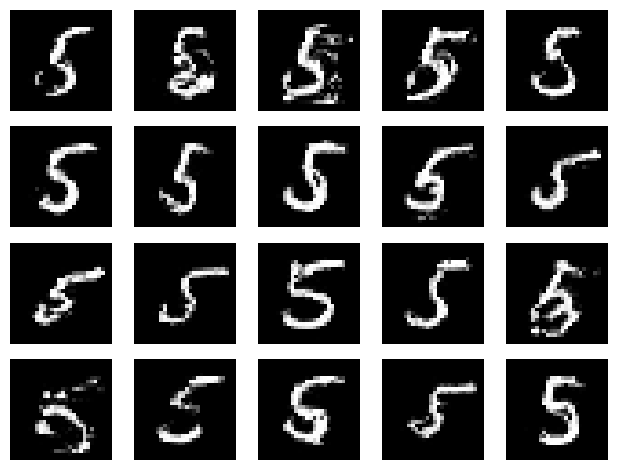

In [20]:
generated_imgs = []
num_of_images = 20
columns = 5
rows = math.ceil(num_of_images / columns)

for i in tqdm(range(num_of_images)):
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    img = generate_image(max_random_idx=196 / 2.5, alpha=1.5)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    generated_imgs.append(img)

plt.tight_layout()
plt.show()

### Reconstruction

100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


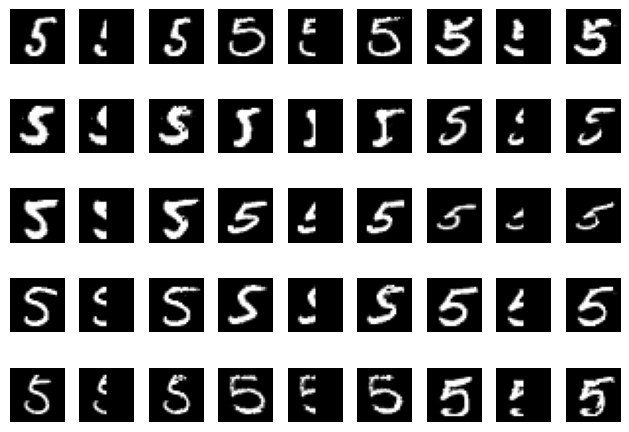

In [13]:
generated_imgs = []
num_of_images = 15 * 3
columns = 9
rows = math.ceil(num_of_images / columns)
pixels_seed = 400


for i in tqdm(range(0, num_of_images, 3)):

    to_reconstruct = test_data[np.random.randint(test_data.shape[0])]
    generated_image, indexes_of_patches = init_image(
        patch_size, to_reconstruct, pixels_seed=pixels_seed
    )
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    to_plot = plot_image(to_reconstruct, return_image=True)
    plt.imshow(to_plot.reshape(28, 28), cmap="gray")

    tmp = generated_image + [0] * (n_pixels - pixels_seed)
    plt.subplot(rows, columns, i + 2)
    plt.axis("off")
    to_plot = plot_image(tmp, undo_conv=True, return_image=True)
    plt.imshow(to_plot.reshape(28, 28), cmap="gray")

    img = generate_image(max_random_idx=0, alpha=0, image=to_reconstruct, pixels_seed=pixels_seed)
    plt.subplot(rows, columns, i + 3)
    plt.axis("off")
    plt.imshow(img.reshape(28, 28), cmap="gray")
    generated_imgs.append(img)

plt.tight_layout()
plt.show()